# Financial Sentiment Analysis Using a Transformer-Based Neural Network for NLP


Tech Stack:


Python
* Programming language for data handling, modeling, and metric visualization

PyTorch / CUDA
* Deep learning framework accelerated on GPU for  model training

DistilBERT
* Lightweight transformer‑based model (6 layers, 66M parameters) for NLP tasks

Hugging Face
* Pre-trained models, tokenization, and training/evaluation APIs

Dataset
* Financial PhraseBank
* Split dataset: train/validation/test (70/15/15)

Transformers
* Implements pre-trained NLP models (DistilBERT)
* Handles tokenization, batching, and model I/O

Scikit-learn
* Evaluation metrics: accuracy, precision, recall, FQ
* Label performance metrics

NumPy
* Numerical computing for array operations in model processing, metrics, and data handling

Matplotlib
* Visualization of training curves, evaluation metrics, and data



# Set Up


In [ ]:
# Upgrades
!pip install --upgrade transformers datasets --quiet

# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from datasets import Value, ClassLabel

# Warning suppression
import warnings
import logging
warnings.filterwarnings("ignore")
logging.getLogger("transformers").setLevel(logging.ERROR)

# Hugging Face Transformers & Datasets
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback)
from datasets import Dataset, DatasetDict

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Retrieve data
file_paths = [
    '/content/Sentences_50Agree.txt',
    '/content/Sentences_66Agree.txt',
    '/content/Sentences_75Agree.txt',
    '/content/Sentences_AllAgree.txt'
]

texts = []
labels = []

for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                # Split last occurrence of '@' to separate text and label
                text, label = line.rsplit('@', 1)
                texts.append(text)
                labels.append(label)
            except ValueError:
                print(f"Skipping malformed line in {file_path}: {line}")

# Convert to pandas DataFrame
df = pd.DataFrame({"text": texts, "label": labels})

# Map sentiment labels to integers
label_names = ["negative", "neutral", "positive"]
label_to_id = {label: i for i, label in enumerate(label_names)}
df["label_id"] = df["label"].map(label_to_id)
if df["label_id"].isnull().any():
    raise ValueError("Some labels in your dataset do not match label_names!")
df["label_id"] = df["label_id"].astype(int)

# Split into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["label_id"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label_id"])

# Convert to Hugging Face DatasetDict
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df, preserve_index=False),
    "validation": Dataset.from_pandas(val_df, preserve_index=False),
    "test": Dataset.from_pandas(test_df, preserve_index=False)
})

print(dataset)

# Tokenizer & data collator
MODEL_CHECKPOINT = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_function(batch):
    tokenized = tokenizer(batch["text"], truncation=True, padding=True)
    tokenized["labels"] = batch["label_id"]
    return tokenized

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text", "label", "label_id"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 47.6 MB/s eta 0:00:00
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_id'],
        num_rows: 10346
    })
    validation: Dataset({
        features: ['text', 'label', 'label_id'],
        num_rows: 2217
    })
    test: Dataset({
        features: ['text', 'label', 'label_id'],
        num_rows: 2217
    })
})


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10346 [00:00<?, ? examples/s]

Map:   0%|          | 0/2217 [00:00<?, ? examples/s]

Map:   0%|          | 0/2217 [00:00<?, ? examples/s]

# Baseline Model

* learning rate: 2e-5
* batch size: 32
* epochs: 10
* weight decay: 0.01


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.374900,0.200230,0.930988,0.933402,0.930988,0.931561
2,0.128100,0.147170,0.956698,0.956847,0.956698,0.956684
3,0.060300,0.129106,0.967073,0.967280,0.967073,0.967016
4,0.030100,0.133877,0.972936,0.973014,0.972936,0.972833
5,0.015200,0.142578,0.974741,0.974783,0.974741,0.974758
6,0.011500,0.154213,0.974290,0.974288,0.974290,0.974211
7,0.008300,0.146127,0.974290,0.974293,0.974290,0.974291
8,0.004600,0.152560,0.974290,0.974360,0.974290,0.974316
9,0.003300,0.154955,0.974290,0.974278,0.974290,0.974282
10,0.002900,0.155561,0.973839,0.973821,0.973839,0.973827



=== Baseline Model Validation Metrics ===
eval_loss: 0.1426
eval_accuracy: 0.9747
eval_precision: 0.9748
eval_recall: 0.9747
eval_f1: 0.9748
eval_runtime: 7.6697
eval_samples_per_second: 289.0580
eval_steps_per_second: 9.1270
Weighted ROC-AUC: 0.9907


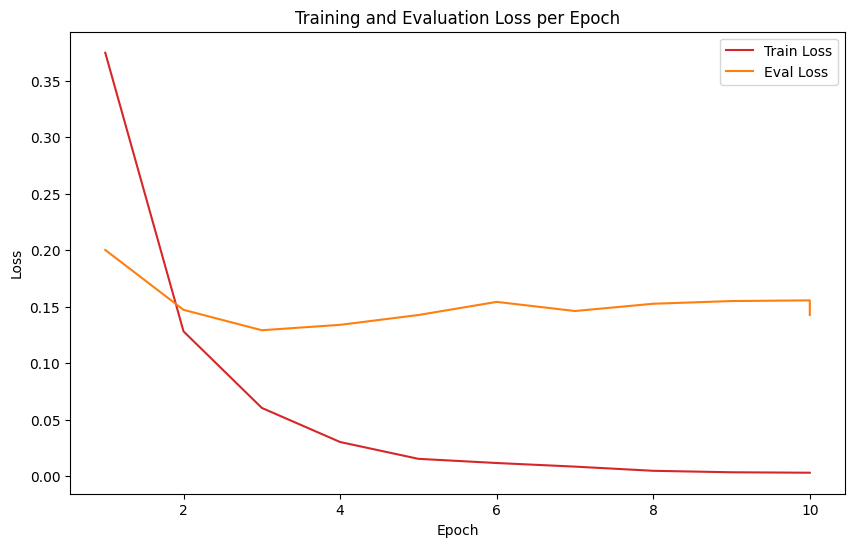

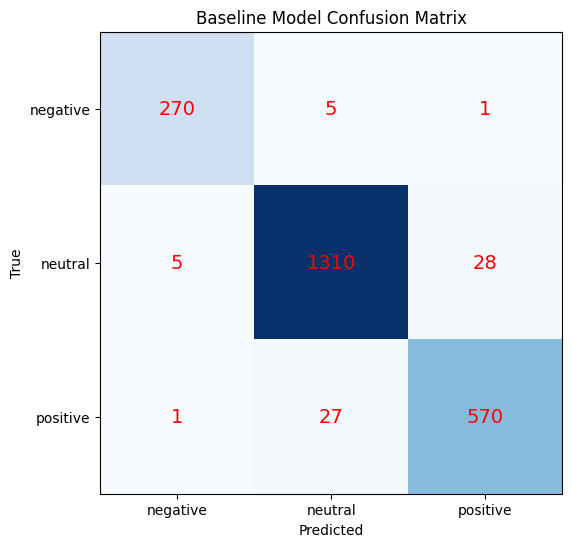

In [ ]:
# Load DistilBERT
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels = len(label_names)  # label_names = ["negative", "neutral", "positive"]
).to(device)  # Move model to GPU

# Define metric function for Hugging Face Trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Training arguments for Hugging Face Trainer
training_args = TrainingArguments(
    output_dir="./phase1_baseline",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32, # For T4 GPU memory
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
    disable_tqdm=True
)

# Initialize Hugging Face Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train model
trainer.train()

# Evaluate on validation set
eval_results = trainer.evaluate()
print("\n=== Baseline Model Validation Metrics ===")
for k, v in eval_results.items():
    if k.startswith("eval_"):
        print(f"{k}: {v:.4f}")

# Performance Metrics and Visuals

log_history = trainer.state.log_history

train_epochs, train_loss = [], []
eval_epochs, eval_loss = [], []

for log in log_history:
    if 'loss' in log:
        train_epochs.append(log.get('epoch'))
        train_loss.append(log.get('loss'))
    if 'eval_loss' in log:
        eval_epochs.append(log.get('epoch'))
        eval_loss.append(log.get('eval_loss'))

# Predictions for test set
preds_output = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

# ROC-AUC (multi-class, one-vs-rest)
labels_binarized = label_binarize(labels, classes=list(range(len(label_names))))
preds_proba = torch.nn.functional.softmax(torch.tensor(preds_output.predictions), dim=1).numpy()
roc_auc = roc_auc_score(labels_binarized, preds_proba, average="weighted", multi_class="ovr")
print(f"Weighted ROC-AUC: {roc_auc:.4f}")

# Plot training and evaluation loss
plt.figure(figsize=(10,6))
plt.plot(train_epochs, train_loss, label="Train Loss", color="tab:red")
plt.plot(eval_epochs, eval_loss, label="Eval Loss", color="tab:orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss per Epoch")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(labels, preds)
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(len(label_names)))
ax.set_yticks(range(len(label_names)))
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Baseline Model Confusion Matrix")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="red", fontsize=14)
plt.show()

# Improved Model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.746800,0.303989,0.900767,0.901275,0.900767,0.900502
2,0.235100,0.194540,0.931439,0.933957,0.931439,0.932049
3,0.128500,0.162825,0.955345,0.956719,0.955345,0.955585
4,0.070000,0.137311,0.965719,0.965742,0.965719,0.965615
5,0.037900,0.138611,0.972034,0.972099,0.972034,0.971924
6,0.020600,0.150829,0.972034,0.972098,0.972034,0.972059
7,0.013300,0.159978,0.974290,0.974247,0.974290,0.974238
8,0.009800,0.145214,0.974741,0.974783,0.974741,0.974756
9,0.006600,0.180756,0.974290,0.974293,0.974290,0.974291
10,0.009400,0.176891,0.974290,0.974439,0.974290,0.974335



=== Baseline Model Validation Metrics ===
eval_loss: 0.1452
eval_accuracy: 0.9747
eval_precision: 0.9748
eval_recall: 0.9747
eval_f1: 0.9748
eval_runtime: 7.8395
eval_samples_per_second: 282.7990
eval_steps_per_second: 8.9290
Weighted ROC-AUC: 0.9924


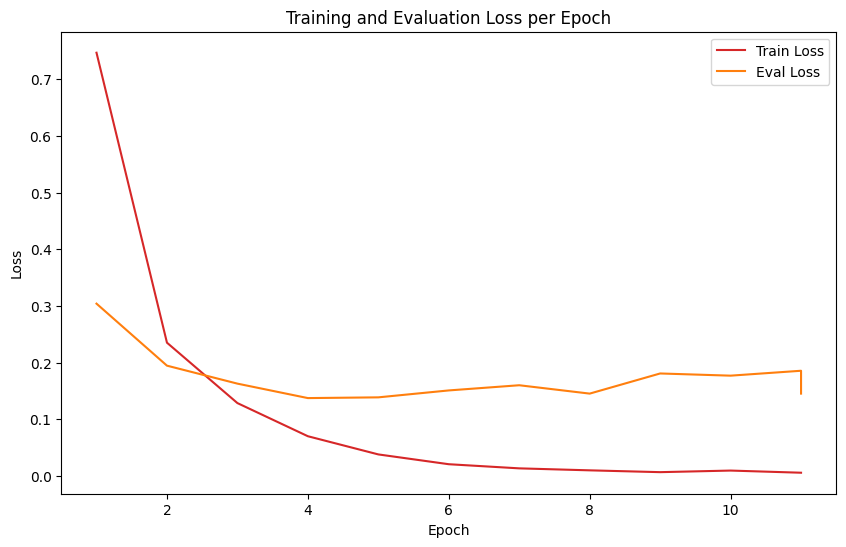

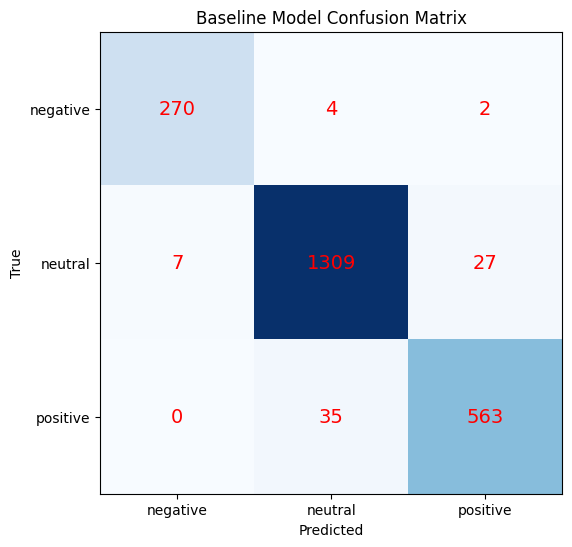

In [ ]:
# Load DistilBERT
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels = len(label_names)  # label_names = ["negative", "neutral", "positive"]
).to(device)  # Move model to GPU

# Define metric function for Hugging Face Trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Training arguments for Hugging Face Trainer
training_args = TrainingArguments(
    output_dir="./phase1_baseline",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    per_device_train_batch_size=32, # For T4 GPU memory
    per_device_eval_batch_size=32,
    num_train_epochs=25,
    weight_decay=0.05,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

# Initialize Hugging Face Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train model
trainer.train()

# Evaluate on validation set
eval_results = trainer.evaluate()
print("\n=== Improved Model Validation Metrics ===")
for k, v in eval_results.items():
    if k.startswith("eval_"):
        print(f"{k}: {v:.4f}")

# Performance Metrics and Visuals

log_history = trainer.state.log_history

train_epochs, train_loss = [], []
eval_epochs, eval_loss = [], []

for log in log_history:
    if 'loss' in log:
        train_epochs.append(log.get('epoch'))
        train_loss.append(log.get('loss'))
    if 'eval_loss' in log:
        eval_epochs.append(log.get('epoch'))
        eval_loss.append(log.get('eval_loss'))

# Predictions for test set
preds_output = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

# ROC-AUC (multi-class, one-vs-rest)
labels_binarized = label_binarize(labels, classes=list(range(len(label_names))))
preds_proba = torch.nn.functional.softmax(torch.tensor(preds_output.predictions), dim=1).numpy()
roc_auc = roc_auc_score(labels_binarized, preds_proba, average="weighted", multi_class="ovr")
print(f"Weighted ROC-AUC: {roc_auc:.4f}")

# Plot training and evaluation loss
plt.figure(figsize=(10,6))
plt.plot(train_epochs, train_loss, label="Train Loss", color="tab:red")
plt.plot(eval_epochs, eval_loss, label="Eval Loss", color="tab:orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss per Epoch")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(labels, preds)
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(len(label_names)))
ax.set_yticks(range(len(label_names)))
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Improved Model Confusion Matrix")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="red", fontsize=14)
plt.show()

# TO-DO

